Epoch 0: ELBO = -4003.70, Recon Loss = 3853.42, KL Div = 150.27
Epoch 100: ELBO = -1638.43, Recon Loss = 677.05, KL Div = 961.38
Epoch 200: ELBO = -1564.46, Recon Loss = 584.45, KL Div = 980.01
Epoch 300: ELBO = -1526.74, Recon Loss = 525.66, KL Div = 1001.08
Epoch 400: ELBO = -1520.07, Recon Loss = 501.59, KL Div = 1018.48
Epoch 500: ELBO = -1514.82, Recon Loss = 494.84, KL Div = 1019.98
Epoch 600: ELBO = -1547.80, Recon Loss = 541.80, KL Div = 1006.00
Epoch 700: ELBO = -1523.38, Recon Loss = 513.22, KL Div = 1010.16
Epoch 800: ELBO = -1495.81, Recon Loss = 462.33, KL Div = 1033.48
Epoch 900: ELBO = -1486.35, Recon Loss = 488.96, KL Div = 997.39


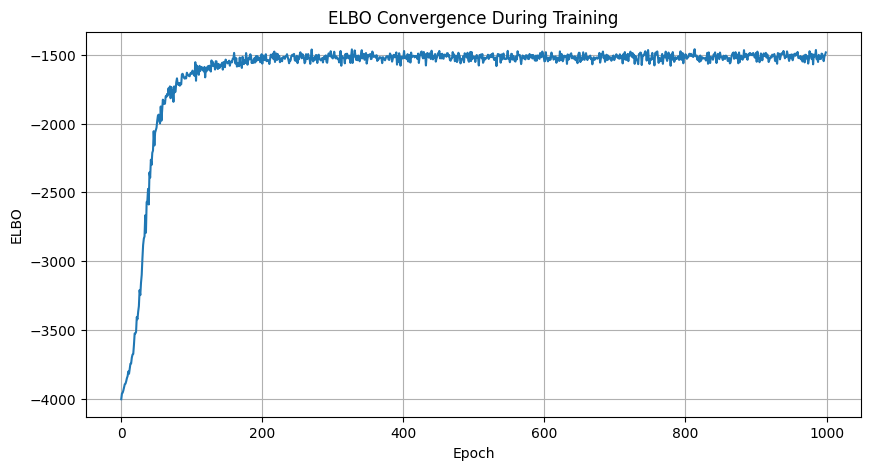

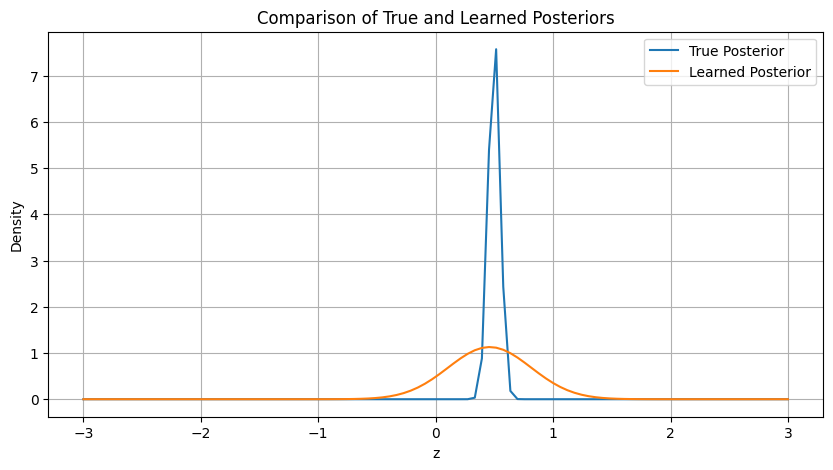

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import torch
import torch.nn as nn
import torch.distributions as dist

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

class VariationalAutoencoder(nn.Module):
    def __init__(self, latent_dim=1):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder (q_φ(z|x))
        self.encoder = nn.Sequential(
            nn.Linear(1, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * latent_dim)  # Mean and log variance
        )
        
        # Decoder (p_θ(x|z))
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu, log_var = h.chunk(2, dim=-1)
        return mu, log_var
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        return self.decode(z), mu, log_var

def compute_elbo(x, x_recon, mu, log_var):
    # Reconstruction loss (expected log-likelihood)
    recon_loss = nn.MSELoss(reduction='sum')(x_recon, x)
    
    # KL divergence
    kl_div = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    # ELBO = -reconstruction_loss - KL_divergence
    elbo = -recon_loss - kl_div
    
    return elbo, recon_loss, kl_div

# Generate synthetic data
true_z = np.random.normal(0, 1, 1000)
x = 2 * true_z + np.random.normal(0, 0.1, 1000)  # True generative process

# Convert to PyTorch tensors
x_tensor = torch.FloatTensor(x).reshape(-1, 1)

# Train VAE
model = VariationalAutoencoder()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

n_epochs = 1000
elbo_values = []

for epoch in range(n_epochs):
    optimizer.zero_grad()
    
    # Forward pass
    x_recon, mu, log_var = model(x_tensor)
    
    # Compute ELBO
    elbo, recon_loss, kl_div = compute_elbo(x_tensor, x_recon, mu, log_var)
    
    # Maximize ELBO (minimize negative ELBO)
    loss = -elbo
    loss.backward()
    optimizer.step()
    
    if epoch % 100 == 0:
        print(f'Epoch {epoch}: ELBO = {elbo.item():.2f}, '
              f'Recon Loss = {recon_loss.item():.2f}, '
              f'KL Div = {kl_div.item():.2f}')
        
    elbo_values.append(elbo.item())

# Plot ELBO convergence
plt.figure(figsize=(10, 5))
plt.plot(elbo_values)
plt.title('ELBO Convergence During Training')
plt.xlabel('Epoch')
plt.ylabel('ELBO')
plt.grid(True)
plt.show()

# Compare learned posterior with true posterior
z_test = torch.linspace(-3, 3, 100).reshape(-1, 1)
x_test = torch.FloatTensor([1.0]).reshape(-1, 1)  # Fixed observation

with torch.no_grad():
    mu, log_var = model.encode(x_test)
    learned_posterior = dist.Normal(mu.item(), torch.exp(0.5 * log_var).item())
    
    # True posterior (analytical for this simple case)
    true_posterior_mean = (2 * x_test.item()) / (4 + 0.1**2)
    true_posterior_std = np.sqrt(1 / (1/1 + 4/0.1**2))
    true_posterior = dist.Normal(true_posterior_mean, true_posterior_std)

plt.figure(figsize=(10, 5))
plt.plot(z_test.numpy(), true_posterior.log_prob(z_test).exp().numpy(), 
         label='True Posterior')
plt.plot(z_test.numpy(), learned_posterior.log_prob(z_test).exp().numpy(), 
         label='Learned Posterior')
plt.title('Comparison of True and Learned Posteriors')
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.show()

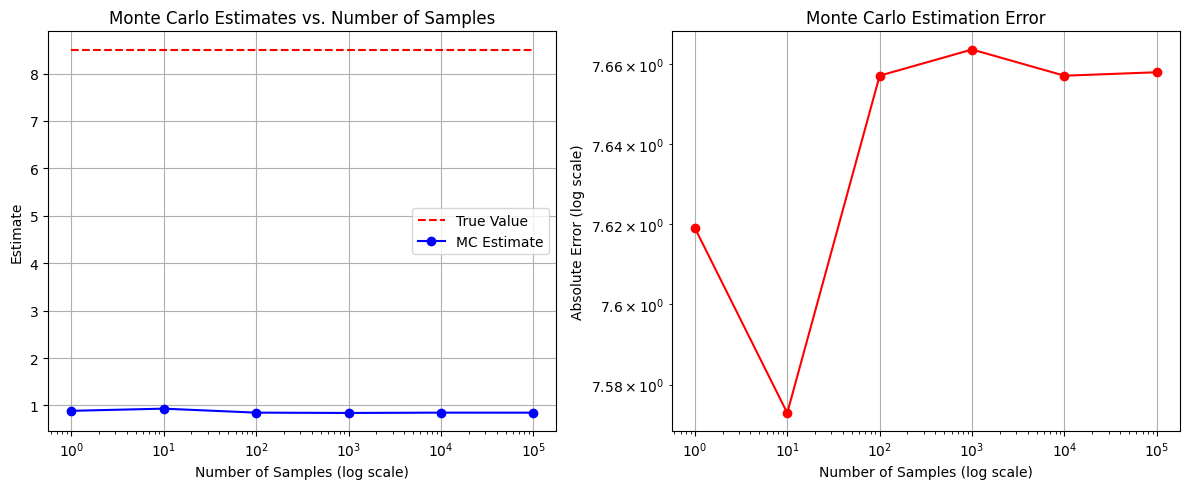


Numerical Results:
True value: 8.506119728088379

Number of Samples | MC Estimate | Absolute Error
---------------------------------------------
              1 |     0.8871 |        7.6190
             10 |     0.9332 |        7.5730
            100 |     0.8490 |        7.6571
           1000 |     0.8424 |        7.6637
          10000 |     0.8490 |        7.6571
         100000 |     0.8481 |        7.6580


In [4]:
import torch
import torch.nn as nn
import torch.distributions as dist
import matplotlib.pyplot as plt
import numpy as np

class SimpleVAE(nn.Module):
    def __init__(self, input_dim=2, latent_dim=1):
        super().__init__()
        self.latent_dim = latent_dim
        
        # Encoder network (q(z|x))
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 2 * latent_dim)  # Output μ and log(σ²)
        )
        
    def encode(self, x):
        # Get distributional parameters
        params = self.encoder(x)
        mu, log_var = params.chunk(2, dim=-1)
        return mu, log_var
    
    def sample_z(self, mu, log_var, num_samples=1):
        # Reparameterization trick for multiple samples
        std = torch.exp(0.5 * log_var)
        eps = torch.randn(num_samples, *mu.shape).to(mu.device)
        return mu + eps * std

def demonstrate_monte_carlo(model, x, num_samples_list=[1, 10, 100, 1000]):
    """Demonstrate Monte Carlo estimation with different numbers of samples"""
    
    # Define a function we want to estimate expectation of
    def a_function(z):
        # Example function: squared norm of z
        return torch.norm(z, dim=-1)**2
    
    # Get distributional parameters
    with torch.no_grad():
        mu, log_var = model.encode(x)
        
        # True value (analytical for this simple case)
        true_expectation = torch.sum(mu**2 + torch.exp(log_var))
        
        estimates = []
        errors = []
        
        # Compute Monte Carlo estimates with different numbers of samples
        for n_samples in num_samples_list:
            # Sample z using reparameterization
            z_samples = model.sample_z(mu, log_var, num_samples=n_samples)
            
            # Compute Monte Carlo estimate
            mc_estimate = torch.mean(a_function(z_samples))
            
            estimates.append(mc_estimate.item())
            errors.append(abs(mc_estimate.item() - true_expectation.item()))
            
        return estimates, errors, true_expectation.item()

# Create synthetic data and model
torch.manual_seed(42)
x = torch.randn(10, 2)  # Batch of 10 2D points
model = SimpleVAE()

# Demonstrate Monte Carlo estimation
num_samples_list = [1, 10, 100, 1000, 10000, 100000]
estimates, errors, true_value = demonstrate_monte_carlo(model, x, num_samples_list)

# Plotting
plt.figure(figsize=(12, 5))

# Plot estimates
plt.subplot(1, 2, 1)
plt.plot(num_samples_list, [true_value] * len(num_samples_list), 'r--', label='True Value')
plt.plot(num_samples_list, estimates, 'bo-', label='MC Estimate')
plt.xscale('log')
plt.xlabel('Number of Samples (log scale)')
plt.ylabel('Estimate')
plt.title('Monte Carlo Estimates vs. Number of Samples')
plt.legend()
plt.grid(True)

# Plot errors
plt.subplot(1, 2, 2)
plt.plot(num_samples_list, errors, 'ro-')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Number of Samples (log scale)')
plt.ylabel('Absolute Error (log scale)')
plt.title('Monte Carlo Estimation Error')
plt.grid(True)

plt.tight_layout()
plt.show()

# Print numerical results
print("\nNumerical Results:")
print("True value:", true_value)
print("\nNumber of Samples | MC Estimate | Absolute Error")
print("-" * 45)
for n, est, err in zip(num_samples_list, estimates, errors):
    print(f"{n:15d} | {est:10.4f} | {err:13.4f}")

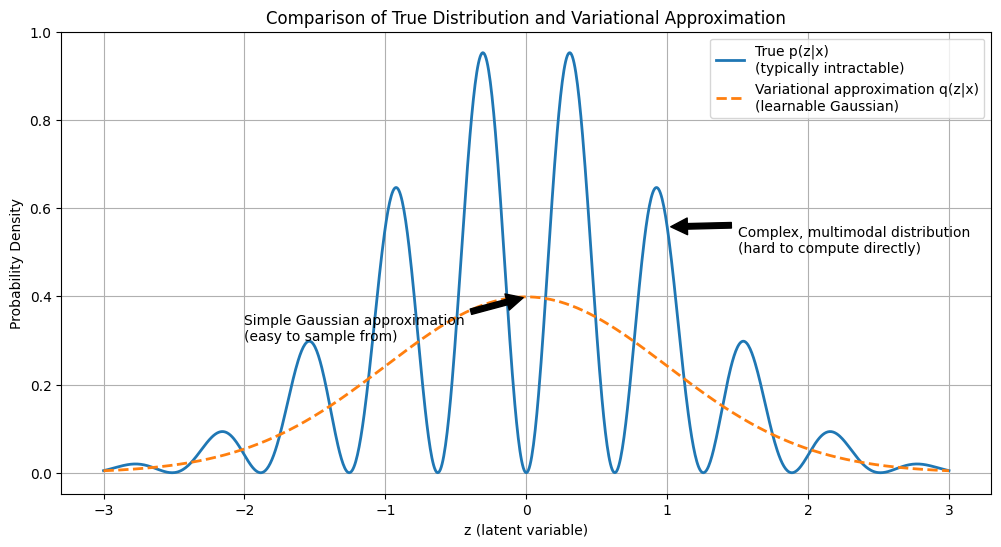

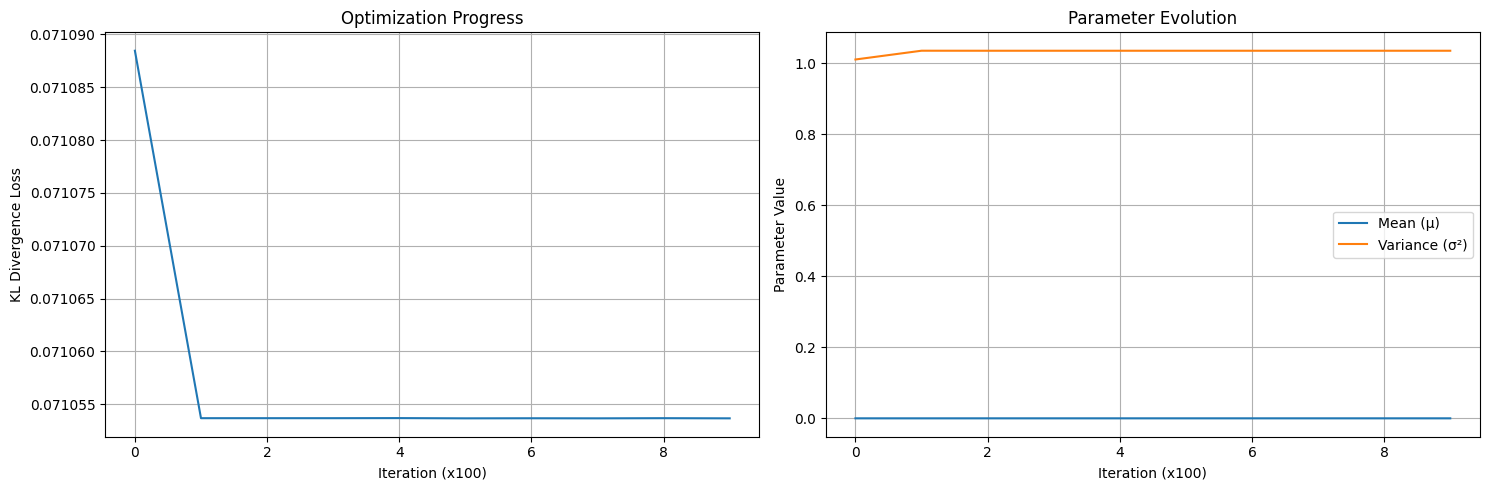

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.distributions as dist

class VariationalExample:
    def __init__(self):
        # True complex distribution (imagine this is p(z|x))
        # In reality, this would be intractable to compute
        self.true_distribution = lambda z: np.exp(-z**2/2) * np.sin(5*z)**2
        
        # Our variational approximation q(z|x)
        # We'll use a Gaussian with learnable parameters
        self.mu = nn.Parameter(torch.tensor(0.0))
        self.log_var = nn.Parameter(torch.tensor(0.0))
        
    def q_distribution(self, z):
        # Our simpler, learnable distribution
        return torch.exp(-0.5 * ((z - self.mu)**2 / torch.exp(self.log_var))) / \
               torch.sqrt(2 * np.pi * torch.exp(self.log_var))
    
    def plot_distributions(self, z_range=np.linspace(-3, 3, 1000)):
        # Plot both the true and approximated distributions
        plt.figure(figsize=(12, 6))
        
        # True distribution
        plt.plot(z_range, self.true_distribution(z_range), 
                label='True p(z|x)\n(typically intractable)', 
                linewidth=2)
        
        # Variational approximation
        q_values = self.q_distribution(torch.tensor(z_range)).detach().numpy()
        plt.plot(z_range, q_values, 
                label='Variational approximation q(z|x)\n(learnable Gaussian)', 
                linewidth=2, linestyle='--')
        
        plt.title('Comparison of True Distribution and Variational Approximation')
        plt.xlabel('z (latent variable)')
        plt.ylabel('Probability Density')
        plt.legend()
        plt.grid(True)
        
        # Add annotations explaining key concepts
        plt.annotate('Complex, multimodal distribution\n(hard to compute directly)',
                    xy=(1, self.true_distribution(1)),
                    xytext=(1.5, 0.5),
                    arrowprops=dict(facecolor='black', shrink=0.05))
        
        plt.annotate('Simple Gaussian approximation\n(easy to sample from)',
                    xy=(0, self.q_distribution(torch.tensor(0.0)).item()),
                    xytext=(-2, 0.3),
                    arrowprops=dict(facecolor='black', shrink=0.05))
        
        plt.show()

    def optimize_approximation(self, n_steps=1000):
        # Demonstrate the optimization process
        optimizer = torch.optim.Adam([self.mu, self.log_var], lr=0.01)
        
        losses = []
        mus = []
        vars = []
        
        for step in range(n_steps):
            optimizer.zero_grad()
            
            # Sample points for Monte Carlo estimation
            z = torch.linspace(-3, 3, 100)
            
            # Compute KL divergence (approximately)
            q_vals = self.q_distribution(z)
            p_vals = torch.tensor(self.true_distribution(z.numpy()))
            
            # Avoid log(0)
            eps = 1e-10
            loss = torch.mean(q_vals * (torch.log(q_vals + eps) - torch.log(p_vals + eps)))
            
            loss.backward()
            optimizer.step()
            
            if step % 100 == 0:
                losses.append(loss.item())
                mus.append(self.mu.item())
                vars.append(torch.exp(self.log_var).item())
        
        # Plot optimization progress
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        ax1.plot(losses)
        ax1.set_title('Optimization Progress')
        ax1.set_xlabel('Iteration (x100)')
        ax1.set_ylabel('KL Divergence Loss')
        ax1.grid(True)
        
        ax2.plot(mus, label='Mean (μ)')
        ax2.plot(vars, label='Variance (σ²)')
        ax2.set_title('Parameter Evolution')
        ax2.set_xlabel('Iteration (x100)')
        ax2.set_ylabel('Parameter Value')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

# Create and demonstrate the example
example = VariationalExample()
example.plot_distributions()
example.optimize_approximation()